<a href="https://colab.research.google.com/github/edliu2/UsedCarsProject/blob/master/kPCA_LinearReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initial modelling to determine # of components

In [9]:
Ny_components = 4000 # number of samples in Nystroem subset, also number of components created
                     # limited by the available RAM 
                     # use <=1000 for Colab instance (12GB RAM)
                     # 4000 worked on GCP instance (64GB RAM)

In [10]:
# Approximate Kernel PCA using Nystroem

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [11]:
# Import required libraries for approximate Kernel PCA
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

#Normalizing the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Nystroem approximation on a subset of data
# (used because kernelPCA is not feasible on the large dataset)
Ny = Nystroem(n_components=Ny_components, random_state=0)
X_train = Ny.fit_transform(X_train)
X_test = Ny.transform(X_test)

#Linear PCA
PCAObj = PCA(n_components=None, random_state=0)
X_train = PCAObj.fit_transform(X_train)
X_test = PCAObj.transform(X_test)


Number of components with 0.95 cumulative variance:  241


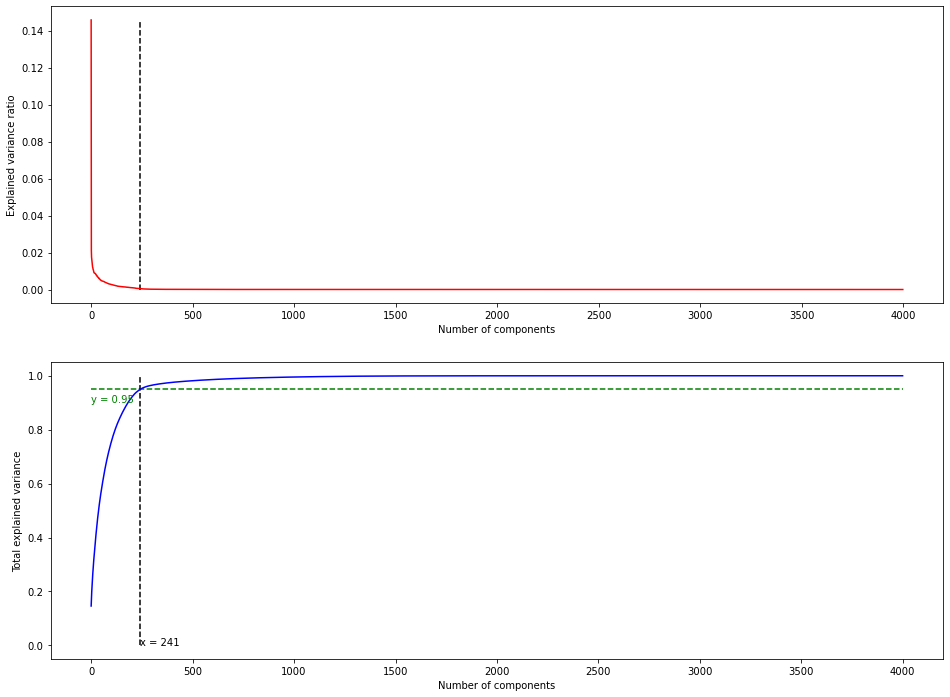

In [12]:
# Define cumulative explained variance ratio
total_variance = np.cumsum(PCAObj.explained_variance_ratio_)

# Show when total_variance is 0.95 using a plot
plt.figure(1, figsize=[16,12])
plot1 = plt.subplot(211)
plt.plot(PCAObj.explained_variance_ratio_, c='red')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

plot2 = plt.subplot(212)
plt.plot(total_variance, c='blue')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
# Look for where cumulative explained variance is 0.95
expl_95_index = np.where((total_variance > 0.949) & (total_variance < 0.951))[0][0]
print('Number of components with 0.95 cumulative variance: ', expl_95_index)
plt.hlines(0.95, 0, len(total_variance), linestyles='dashed', color='green')
plt.vlines(expl_95_index, 0, 1, linestyles='dashed')
plot1.vlines(expl_95_index, 0, np.max(PCAObj.explained_variance_ratio_), linestyles='dashed')
plt.text(0, 0.95-0.05, 'y = 0.95', color='green')
plt.text(expl_95_index+2, 0, 'x = '+str(expl_95_index))

plt.show()

# Clear variables except the index and Ny_components to "reset" the runtime

In [13]:
%reset_selective -f ^(?!expl_95_index|Ny_components).*$ 

## Run PCA with the # of components from above

In [14]:
#Kernal PCA (Nystroem approximation)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [15]:
# Import required libraries for making a PCA pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Pipeline for predicting the target
LR_PCA_pipeline = Pipeline([
                    ('scale', StandardScaler()), 
                    ('Ny', Nystroem(n_components=Ny_components, random_state=0)),
                    ('PCA', PCA(n_components=expl_95_index, random_state=0)),
                    ('LR', LinearRegression())
                     ], verbose=True)

LR_PCA_pipeline.fit(X_train, y_train)
y_pred = LR_PCA_pipeline.predict(X_test)

[Pipeline] ............. (step 1 of 4) Processing scale, total=   1.5s
[Pipeline] ................ (step 2 of 4) Processing Ny, total= 1.4min
[Pipeline] ............... (step 3 of 4) Processing PCA, total= 1.6min
[Pipeline] ................ (step 4 of 4) Processing LR, total=   2.2s


In [16]:
# Evaluating the model
print(mean_squared_error(y_test, y_pred))

print(10**y_test)
print(10**y_pred)
print(mean_squared_error(10**y_test, 10**y_pred))

0.07775042461368689
[ 1300. 10900.  8200. ... 12800.  7500.  3500.]
[  787.92629034 11381.9390791   8149.83560953 ... 12982.08972874
  9874.70002205  3063.78042276]
86176888.96506321
